### Import packages

In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision

In [74]:
import numpy as np
import pandas as pd 
import keras
import torch

from sklearn.model_selection import GridSearchCV
from sklearn.cross_validation import train_test_split

from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import to_categorical



print(f"Your version of Pytorch is {torch.__version__}. You should use a version >0.4.")

Your version of Pytorch is 0.4.1. You should use a version >0.4.


### Set up Colab

In [75]:
# If a GPU is available, use it
# Pytorch uses an elegant way to keep the code device agnostic
if torch.cuda.is_available():
    device = torch.device("cuda")
    use_cuda = True
else:
    device = torch.device("cpu")
    use_cuda = False
    
print(device)

cuda


In [76]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Import data

In [77]:
bank =pd.read_csv('drive/My Drive/Colab Notebooks/ML_project/bank-full.csv',delimiter=';',header=0)
bank.shape

(45211, 17)

In [0]:
bank.y.replace(('yes','no'),(1,0), inplace=True)

In [79]:
# On transforme toutes les colones comportant des classes en one hot 
t = pd.get_dummies(bank.iloc[:,:-1])
t.shape

(45211, 51)

In [0]:
#print("Data Types:", t.dtypes)

In [81]:
# Séparation des données : features 
features = t.iloc[:,:].values
features.shape

(45211, 51)

In [82]:
# Output y : cest a dire si le client a pris ou non le DAT
output=bank.iloc[:,-1].values
print(output.shape)

(45211,)


In [83]:
x_train_temp, x_test, y_train_temp, y_test = train_test_split(features, output, test_size=0.2, random_state=1)
print(x_train_temp.shape)
print(y_train_temp.shape)

print(" ")
print(x_test.shape)
print(y_test.shape)

x_train,x_valid,y_train, y_valid = train_test_split(x_train_temp, y_train_temp, test_size=0.3, random_state=1)
print(" ")
print(x_valid.shape)
print(y_valid.shape)

(36168, 51)
(36168,)
 
(9043, 51)
(9043,)
 
(10851, 51)
(10851,)


In [84]:
#transformer les outputs en onehot : 
y_train_hot = to_categorical(y_train)
y_valid_hot = to_categorical(y_valid)
y_test_hot = to_categorical(y_test)
y_train_temp_hot = to_categorical(y_train_temp)

print('Original label:', y_train[0])
print('After conversion to one-hot:', y_train_hot[1])

print(y_train_hot.shape)

Original label: 0
After conversion to one-hot: [0. 1.]
(25317, 2)


### Grid search for optimal hyper parameters

In [0]:
# Function to create model, required for KerasClassifier
def create_model():
  # create model
	model = Sequential()
	model.add(Dense(12, input_dim=51, activation='relu'))
	model.add(Dense(2, activation='sigmoid'))
	# Compile model
	model.compile(loss=keras.losses.categorical_crossentropy, optimizer='adam', metrics=['accuracy'])
	return model

model = KerasClassifier(build_fn=create_model, verbose=1)


In [0]:
# define the grid search parameters
batch_size = [40,50, 60]
epochs = [10, 30,50]

param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)

In [72]:
#17h37
grid_result = grid.fit(x_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Epoch 1/10
Epoch 1/10


KeyboardInterrupt: ignored

In [0]:
grid_result = grid.fit(x_train_temp, y_train_temp)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

KeyboardInterrupt: ignored

In [0]:
# define the grid search parameters
learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
param_grid = dict(learn_rate=learn_rate)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)

In [0]:
# define the grid search parameters
activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
param_grid = dict(activation=activation)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)

## modele crée par cheikh

In [0]:
# create model
model = Sequential()
model.add(Dense(40, input_dim=51, init='uniform', activation='relu'))
model.add(Dense(20, init='uniform', activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(Dense(20, init='uniform', activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(Dense(10, init='uniform', activation='relu'))
model.add(Dense(2, init='uniform', activation='relu'))

# Compile model
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

# Fit the model
model_train = model.fit(x_train, y_train_hot, epochs=10, batch_size=50,verbose=1,validation_data=(x_valid, y_valid_hot))




/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(40, input_dim=51, activation="relu", kernel_initializer="uniform")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(20, activation="relu", kernel_constraint=<keras.con..., kernel_initializer="uniform")`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(20, activation="relu", kernel_constraint=<keras.con..., kernel_initializer="uniform")`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, activation="relu", kernel_initializer="uniform")`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update 

Train on 32551 samples, validate on 8138 samples
Epoch 1/10
32551/32551 [==============================] - 7s 210us/step - loss: 0.1183 - acc: 0.9379 - val_loss: 0.1112 - val_acc: 0.8535
Epoch 2/10
32551/32551 [==============================] - 6s 195us/step - loss: 0.0515 - acc: 0.9396 - val_loss: 0.1130 - val_acc: 0.8535
Epoch 3/10
32551/32551 [==============================] - 6s 195us/step - loss: 0.0452 - acc: 0.9396 - val_loss: 0.1069 - val_acc: 0.8543
Epoch 4/10
32551/32551 [==============================] - 6s 196us/step - loss: 0.0447 - acc: 0.9408 - val_loss: 0.1111 - val_acc: 0.8559
Epoch 5/10
32551/32551 [==============================] - 6s 196us/step - loss: 0.0440 - acc: 0.9412 - val_loss: 0.1155 - val_acc: 0.8567
Epoch 6/10
32551/32551 [==============================] - 6s 197us/step - loss: 0.0434 - acc: 0.9433 - val_loss: 0.1140 - val_acc: 0.8589
Epoch 7/10
32551/32551 [==============================] - 6s 195us/step - loss: 0.0440 - acc: 0.9426 - val_loss: 0.1117 - v

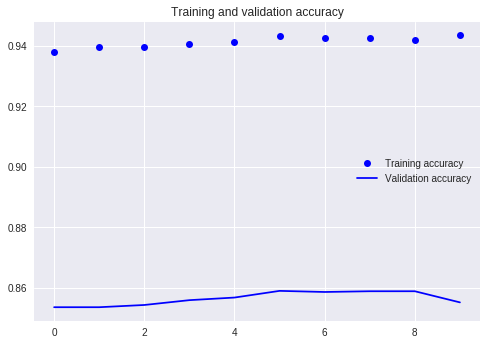

In [0]:
accuracy = model_train.history['acc']
val_accuracy = model_train .history['val_acc']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()